<a href="https://colab.research.google.com/github/wcarolw/VisaoComputacional/blob/main/Solucao_Visao_Classica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalações necessárias
!pip install scikit-learn

In [2]:
# Bibliotecas
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import MinCovDet
import pandas as pd
from tqdm import tqdm


In [3]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# CONFIGURAÇÕES
# Caminho para a pasta com as imagens no seu Google Drive
image_dir = "/content/drive/MyDrive/Visao Computacional/exemplos"

# Pasta onde serão salvas as máscaras e CSV
output_dir = "/content/drive/MyDrive/Visao Computacional/resultados"

os.makedirs(output_dir, exist_ok=True)

# Parâmetros ajustáveis
HSV_LOWER = (10, 30, 100)
HSV_UPPER = (30, 255, 255)
MAHAL_THRESH = 3


In [7]:
# Funções de processamento
def read_img(path):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

def get_leaf_mask(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    return mask

def threshold_hsv(img_rgb, mask):
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    mask_doenca = cv2.inRange(hsv, HSV_LOWER, HSV_UPPER)
    return cv2.bitwise_and(mask_doenca, mask_doenca, mask=mask)

def mahalanobis_mask(img_rgb, mask):
    pixels = img_rgb[mask > 0].reshape(-1, 3).astype(np.float32)
    robust_cov = MinCovDet().fit(pixels)
    diffs = pixels - robust_cov.location_
    mdists = np.sqrt(np.sum((diffs @ np.linalg.inv(robust_cov.covariance_)) * diffs, axis=1))
    lesion = np.zeros(mask.shape, dtype=np.uint8)
    lesion[mask > 0] = (mdists > MAHAL_THRESH).astype(np.uint8) * 255
    return lesion

def calculate_percent(mask_leaf, mask_lesion):
    lesion_area = np.sum(mask_lesion == 255)
    leaf_area = np.sum(mask_leaf == 255)
    return 100 * lesion_area / leaf_area if leaf_area > 0 else 0.0


In [15]:
# Processar imagens
results = []

for filename in tqdm(sorted(os.listdir(image_dir))):
    if not (filename.endswith('.png') or filename.endswith('.jpg')):
        continue

    filepath = os.path.join(image_dir, filename)
    img = read_img(filepath)
    mask_folha = get_leaf_mask(img)

    # Criar subpasta para salvar as etapas desta imagem
    nome_base = os.path.splitext(filename)[0]
    etapa_dir = os.path.join(output_dir, nome_base)
    os.makedirs(etapa_dir, exist_ok=True)

    # Etapa 1: imagem original
    cv2.imwrite(os.path.join(etapa_dir, "1_original.png"), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    # Etapa 2: máscara da folha
    cv2.imwrite(os.path.join(etapa_dir, "2_mascara_folha.png"), mask_folha)

    # Etapa 3: aplicar blur
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    cv2.imwrite(os.path.join(etapa_dir, "3_blur.png"), cv2.cvtColor(blurred, cv2.COLOR_RGB2BGR))

    # Etapa 4: canal H (matiz) visualizado com colormap hsv
    hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)
    h_channel = hsv[:, :, 0]
    plt.imsave(os.path.join(etapa_dir, "4_canal_H.png"), h_channel, cmap='hsv')

    # Etapa 5: máscara HSV binária (raw)
    mask_hsv_raw = cv2.inRange(hsv, HSV_LOWER, HSV_UPPER)
    cv2.imwrite(os.path.join(etapa_dir, "5_hsv_raw.png"), mask_hsv_raw)

    # Etapa 6: aplicar a máscara da folha
    lesion_hsv = cv2.bitwise_and(mask_hsv_raw, mask_hsv_raw, mask=mask_folha)
    cv2.imwrite(os.path.join(etapa_dir, "6_hsv_final_mascara.png"), lesion_hsv)

    # Etapa 7: gerar versão colorida da lesão (regiões com cor original)
    lesion_color = cv2.bitwise_and(img, img, mask=lesion_hsv)
    cv2.imwrite(os.path.join(etapa_dir, "7_hsv_final_colorido.png"), cv2.cvtColor(lesion_color, cv2.COLOR_RGB2BGR))

    # Etapa 8: Mahalanobis
    lesion_mahal = mahalanobis_mask(img, mask_folha)
    cv2.imwrite(os.path.join(etapa_dir, "8_mahalanobis.png"), lesion_mahal)

    # Calcular áreas
    p_hsv = calculate_percent(mask_folha, lesion_hsv)
    p_mahal = calculate_percent(mask_folha, lesion_mahal)

    def classify(percent, threshold=5.0):
        return "com escaldura" if percent >= threshold else "saudável"

    results.append({
        "imagem": filename,
        "pct_lesao_hsv": round(p_hsv, 2),
        "classificacao_hsv": classify(p_hsv),
        "pct_lesao_mahal": round(p_mahal, 2),
        "classificacao_mahal": classify(p_mahal)
    })

    # Também salvar as máscaras finais fora das subpastas
    cv2.imwrite(os.path.join(output_dir, f"{filename}_hsv.png"), lesion_hsv)
    cv2.imwrite(os.path.join(output_dir, f"{filename}_mahal.png"), lesion_mahal)


100%|██████████| 70/70 [14:39<00:00, 12.57s/it]


In [16]:
df = pd.DataFrame(results)
df.to_csv(os.path.join(output_dir, "percentual_lesao.csv"), index=False)

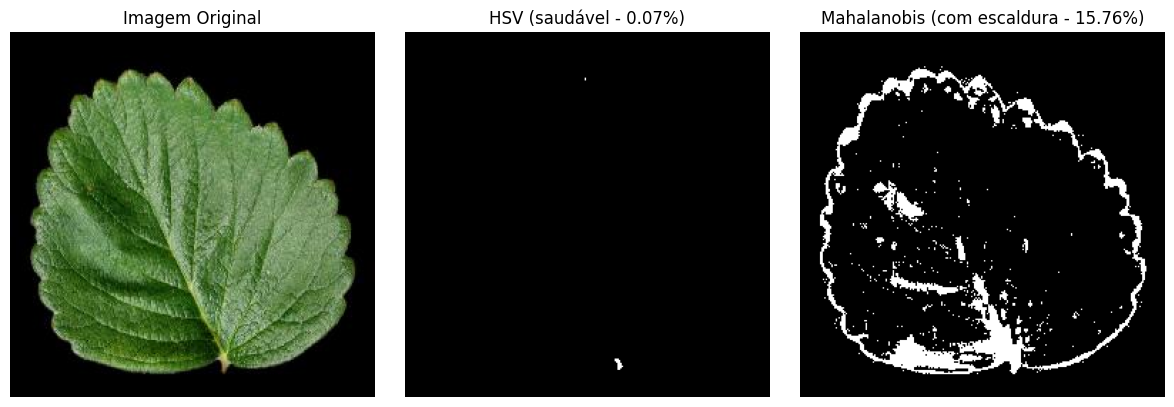

In [17]:
# Mostrar imagem processada com classificações
z=7
example_name = df['imagem'][z]
example = read_img(os.path.join(image_dir, example_name))
mask = get_leaf_mask(example)

lesion_hsv = cv2.imread(os.path.join(output_dir, f"{example_name}_hsv.png"), cv2.IMREAD_GRAYSCALE)
lesion_mahal = cv2.imread(os.path.join(output_dir, f"{example_name}_mahal.png"), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(example)
plt.title("Imagem Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(lesion_hsv, cmap='gray')
plt.title(f"HSV ({df['classificacao_hsv'][z]} - {df['pct_lesao_hsv'][z]}%)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(lesion_mahal, cmap='gray')
plt.title(f"Mahalanobis ({df['classificacao_mahal'][z]} - {df['pct_lesao_mahal'][z]}%)")
plt.axis('off')

plt.tight_layout()
plt.show()


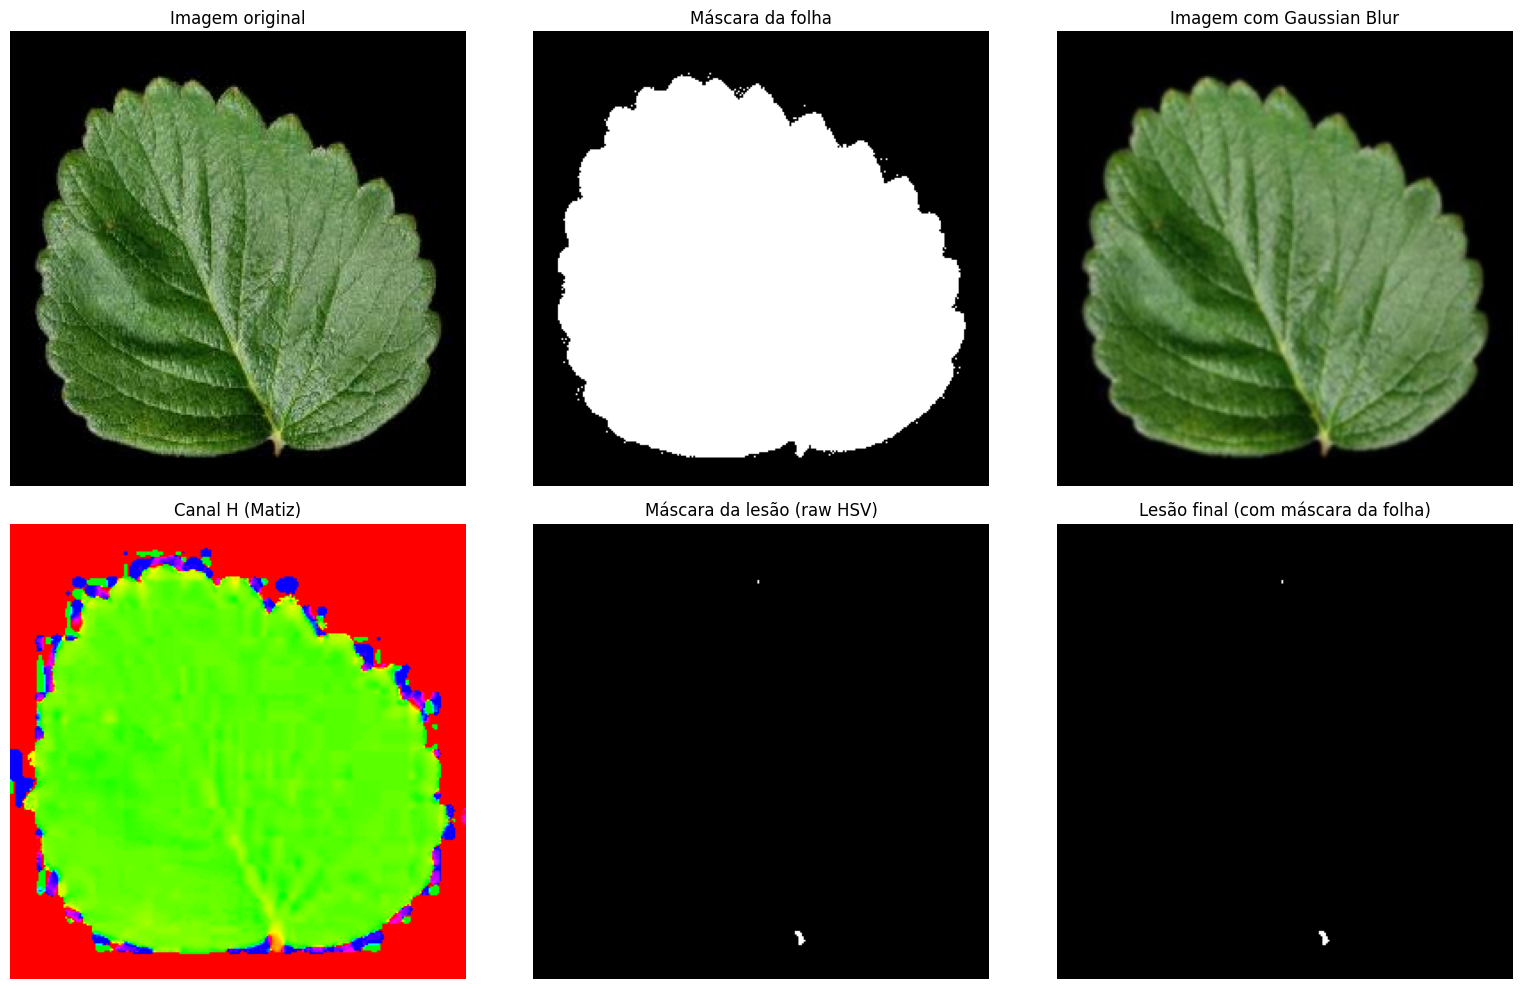

Percentual de escaldura detectado (HSV): 0.07%


In [18]:
# Mostrar etapas do processamento

def detectar_escaldura_hsv_com_visualizacao(img_rgb):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.ravel()

    # Etapa 1: Original
    axes[0].imshow(img_rgb)
    axes[0].set_title("Imagem original")
    axes[0].axis('off')

    # Etapa 2: Máscara da folha (área != preto)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, mask_leaf = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    axes[1].imshow(mask_leaf, cmap='gray')
    axes[1].set_title("Máscara da folha")
    axes[1].axis('off')

    # Etapa 3: Aplicar blur (opcional, para suavizar ruído)
    blurred = cv2.GaussianBlur(img_rgb, (3, 3), 0)
    axes[2].imshow(blurred)
    axes[2].set_title("Imagem com Gaussian Blur")
    axes[2].axis('off')

    # Etapa 4: Converter para HSV
    hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)
    h_channel = hsv[:,:,0]
    axes[3].imshow(h_channel, cmap='hsv')
    axes[3].set_title("Canal H (Matiz)")
    axes[3].axis('off')

    # Etapa 5: Criar máscara de escaldura por threshold HSV
    lesion_mask = cv2.inRange(hsv, HSV_LOWER, HSV_UPPER)
    axes[4].imshow(lesion_mask, cmap='gray')
    axes[4].set_title("Máscara da lesão (raw HSV)")
    axes[4].axis('off')

    # Etapa 6: Aplicar máscara da folha para excluir fundo
    lesion_mask_final = cv2.bitwise_and(lesion_mask, lesion_mask, mask=mask_leaf)
    axes[5].imshow(lesion_mask_final, cmap='gray')
    axes[5].set_title("Lesão final (com máscara da folha)")
    axes[5].axis('off')

    plt.tight_layout()
    plt.show()

    # Calcular área afetada
    pct = calculate_percent(mask_leaf, lesion_mask_final)
    print(f"Percentual de escaldura detectado (HSV): {pct:.2f}%")

    return lesion_mask_final, pct

example_name = df['imagem'][z]
img_path = os.path.join(image_dir, example_name)
img_rgb = read_img(img_path)

# Executar o pipeline HSV com visualização passo a passo
lesion_mask_final, pct = detectar_escaldura_hsv_com_visualizacao(img_rgb)